# Estimating Topics

In [17]:
# IMPORTS
# import numpy as np
# import pandas as pd 
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Set plt parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams["figure.figsize"] = (10,5)

In [2]:
# Import the data into a list of strings
screenplays = []
for p in Path('../queue/screenplays/').glob('*.txt'):
    with open(p, encoding="utf8", errors='ignore') as f:
        contents = f.read()
        screenplays.append(contents)

In [3]:
# While we're at it, let's grab file names
titles= []
for p in Path('../queue/screenplays/').glob('*.txt'):
    with open(p, encoding="utf8", errors='ignore') as f:
        title = p.name[:-4]
        titles.append(title)

The `%%time` cell magic allows us to see how long a cell takes to run. Please note that it must come before anything else in the cell, even comments!

In [4]:
print(len(screenplays))

2858


143,000 dimensions is *a lot* of dimensions. Since we are topic modeling this, let's see what we can do to reduce the words.

In [5]:
%%time

# Vectorize our texts while removing function words
# and words that occur in only one text
vectorizer = TfidfVectorizer(lowercase = True,
                             min_df = 10,
                             stop_words='english')

# fit the model to the data 
matrix = vectorizer.fit_transform(screenplays)

# We'll need these later
vocabulary = vectorizer.get_feature_names_out()

# see how many features we have
matrix.shape

CPU times: user 26 s, sys: 164 ms, total: 26.2 s
Wall time: 26.2 s


(2858, 47208)

In [6]:
%%time

wcss = [] 
for i in range(1, 30): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(matrix) 
    wcss.append(kmeans.inertia_)

CPU times: user 7min, sys: 38.6 s, total: 7min 39s
Wall time: 1min


In [7]:
%%time

# Vectorize our texts while removing function words
# and words that occur in only one text
vectorizer = TfidfVectorizer(lowercase = True,
                             min_df = 2,
                             stop_words='english')

# fit the model to the data 
matrix = vectorizer.fit_transform(screenplays)

# We'll need these later
vocabulary = vectorizer.get_feature_names_out()

# see how many features we have
matrix.shape

CPU times: user 28 s, sys: 319 ms, total: 28.3 s
Wall time: 27.1 s


(2858, 142999)

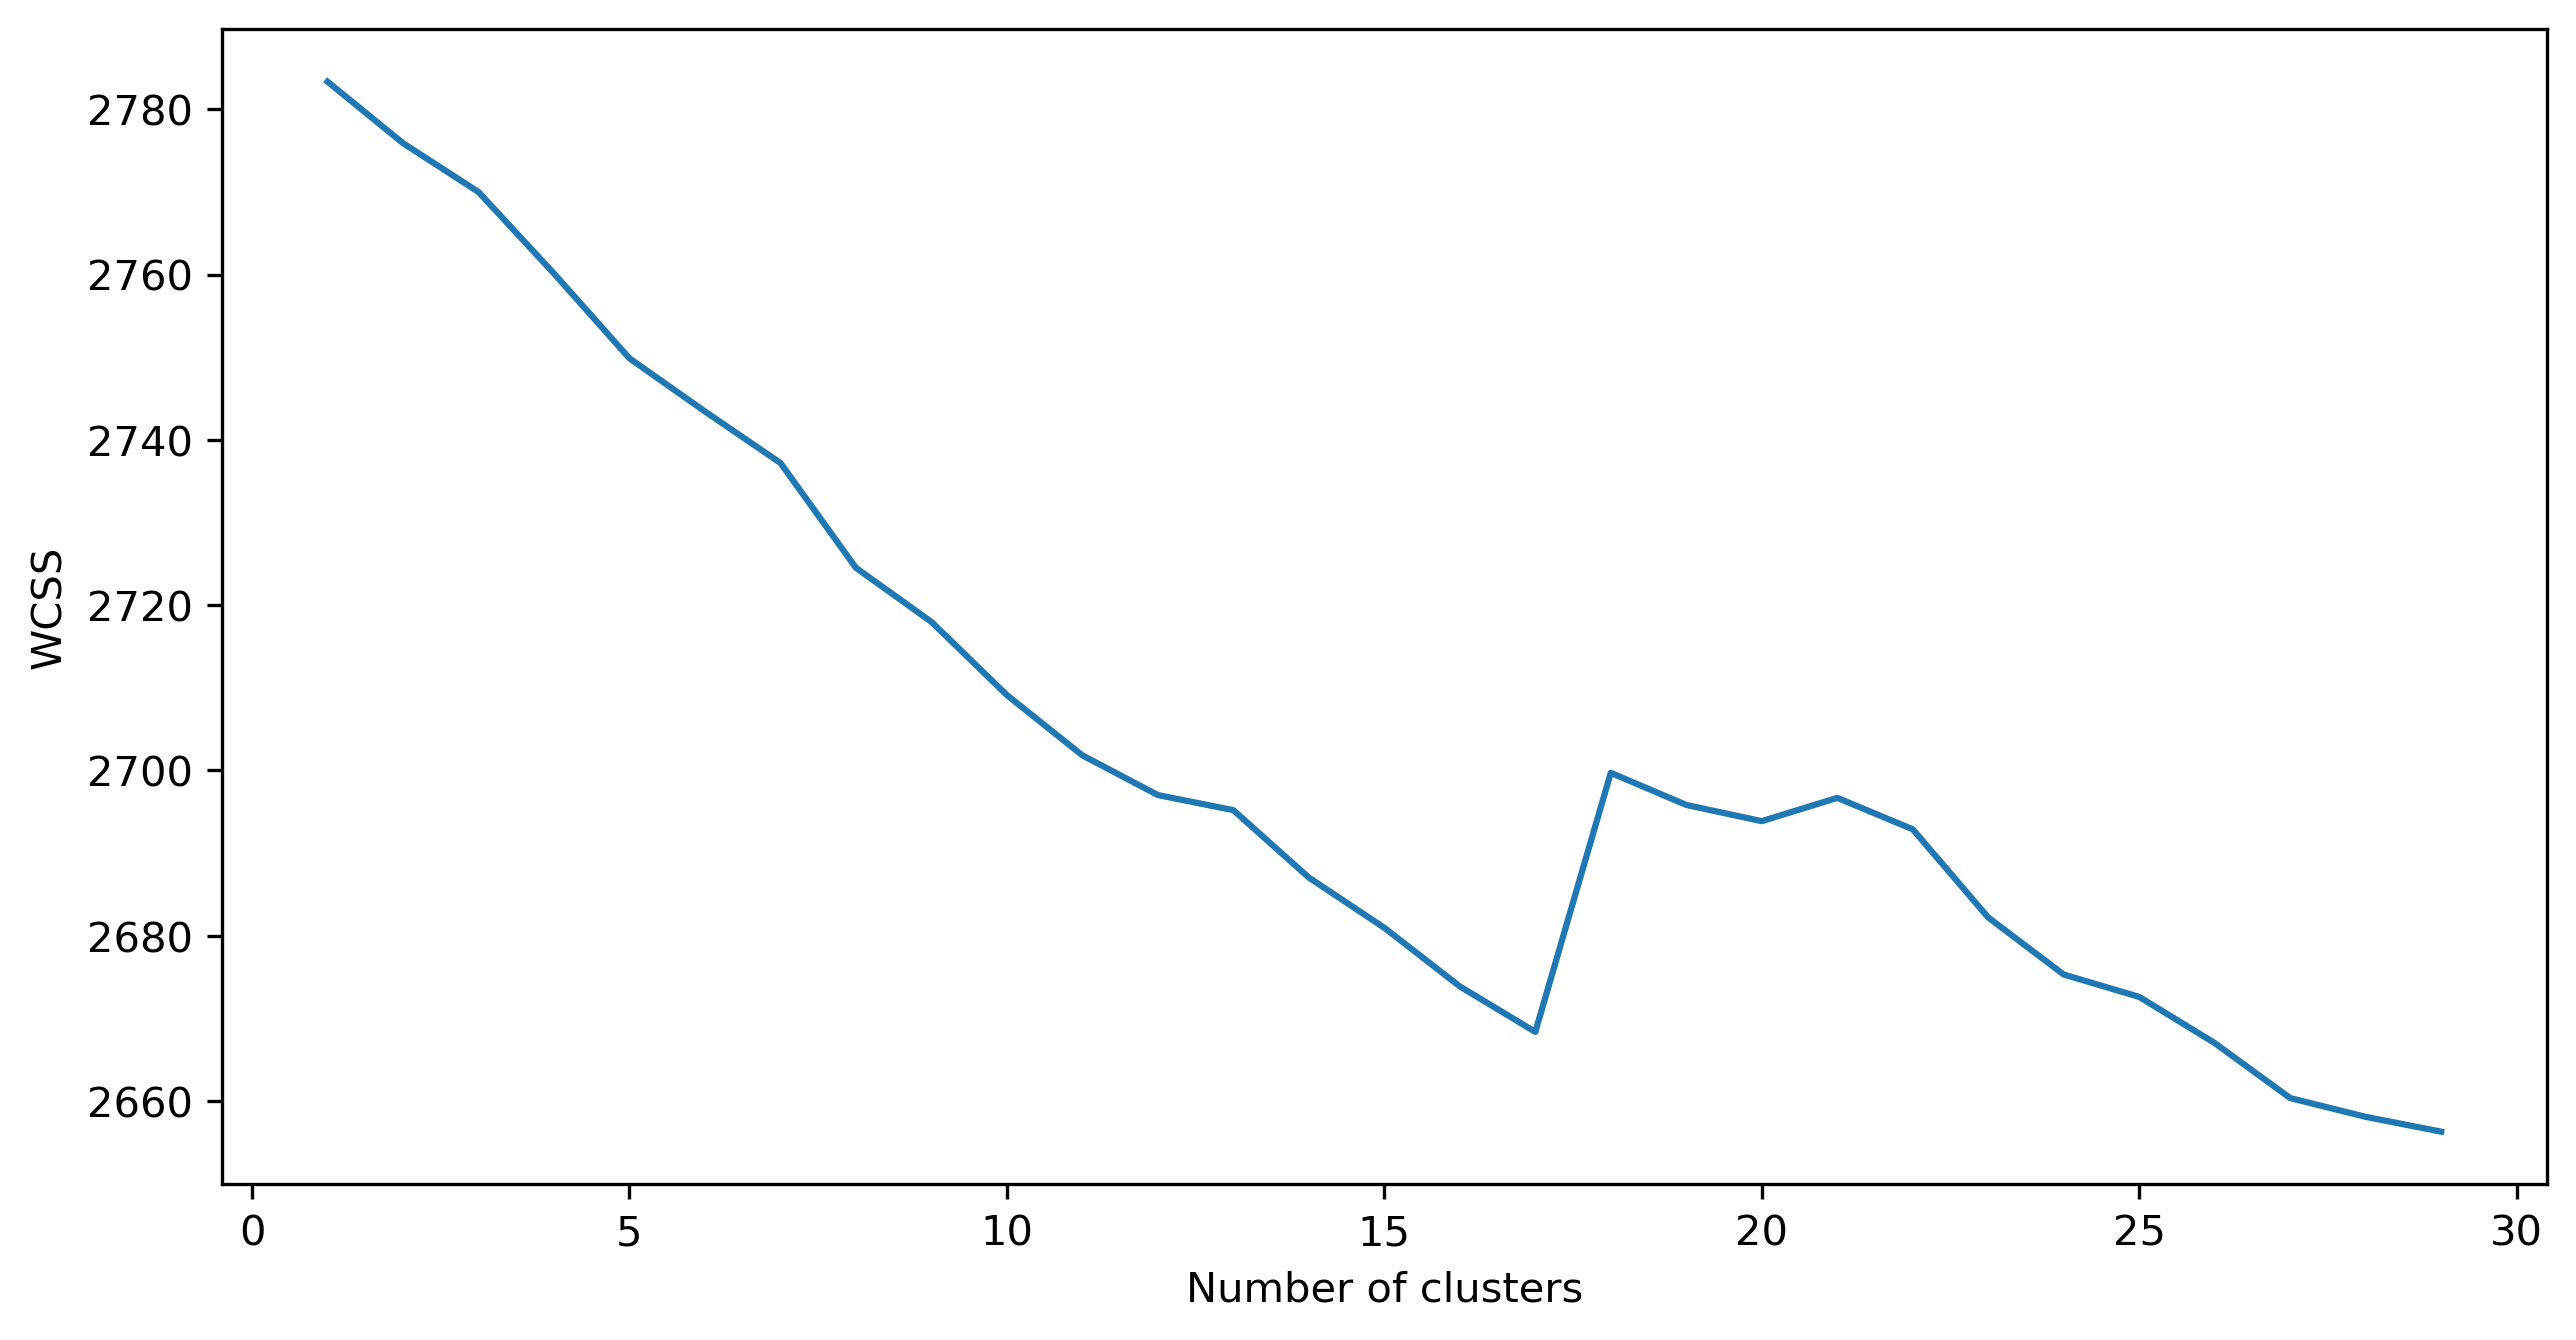

In [8]:
plt.plot(range(1, 30), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

In [9]:
# kmeans = KMeans(n_clusters = 20, init = "k-means++", random_state = 42)
# y_kmeans = kmeans.fit_predict(matrix)

In [12]:
%%time

nmf = NMF(n_components=17, 
          random_state=1, 
          max_iter=500, 
          init='nndsvd').fit(matrix)
nmf_W = nmf.transform(matrix)
nmf_H = nmf.components_
nmf_W.shape

CPU times: user 39.3 s, sys: 1.15 s, total: 40.5 s
Wall time: 32.5 s


(2858, 17)

In [13]:
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "{:d}: ".format(topic_idx)
        message += " ".join([feature_names[i] + ' ' + str(round(topic[i], 2)) + ','
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [14]:
display_topics(nmf, vocabulary, 10)

0: continued 0.76, int 0.63, cont 0.49, don 0.48, looks 0.47, just 0.44, like 0.44, day 0.43, ext 0.4, know 0.39,
1: jack 1.83, kate 0.17, wendy 0.1, danny 0.1, barbossa 0.09, lucy 0.09, int 0.08, eddie 0.07, cont 0.07, susie 0.07,
2: nick 1.82, amy 0.19, kat 0.14, dale 0.09, kurt 0.09, nora 0.09, beth 0.09, joyce 0.08, wynant 0.08, sean 0.07,
3: harry 1.68, hermione 0.44, ron 0.37, dumbledore 0.29, lloyd 0.26, continued 0.18, hagrid 0.16, potter 0.12, perry 0.12, snape 0.11,
4: david 1.8, amy 0.14, shortsighted 0.12, jennifer 0.11, hirsch 0.1, steve 0.1, loner 0.1, nancy 0.1, jeff 0.1, woody 0.09,
5: max 1.87, annie 0.18, julie 0.17, henry 0.12, evelyn 0.1, vincent 0.09, carol 0.09, blume 0.09, jackie 0.08, logan 0.08,
6: sam 2.26, george 0.35, lucy 0.32, annie 0.21, dave 0.17, lila 0.13, henry 0.12, rita 0.11, mike 0.11, gerty 0.11,
7: pageparams 0.62, var 0.61, https 0.48, function 0.47, icon 0.46, scribd 0.41, scribdassets 0.37, prototype 0.37, content 0.34, fonts 0.3,
8: chris 1.9

In [20]:
%%time

# Vectorize the counts
cv = CountVectorizer(lowercase = True,
                     min_df = 10,
                     stop_words='english')

# fit the model to the data 
X = cv.fit_transform(screenplays)

# We'll need these later
lda_vocab = cv.get_feature_names_out()

# see how many features we have
X.shape

CPU times: user 26.7 s, sys: 128 ms, total: 26.8 s
Wall time: 26.9 s


(2858, 47208)

In [19]:
%%time

lda = LDA(n_components=17).fit(matrix)

CPU times: user 4min 50s, sys: 34.4 s, total: 5min 24s
Wall time: 44.1 s


In [22]:
display_topics(lda, lda_vocab, 10)

IndexError: index 78249 is out of bounds for axis 0 with size 47208